#LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
from time import time
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

#Data Loading and One Hot Encoding

In [ ]:
# Function to load data from a file
def load_data(file_path):
    return np.load(file_path)

# One-hot encoding function
def onehot_encoding(list_input):
    r = len(list_input)
    c = len(np.unique(list_input))
    matrix_output = np.zeros((r, c))
    for i in range(r):
        j = list_input[i][0]  # Adjusting for numpy array indexing
        matrix_output[i, j] = 1
    return matrix_output

# Load label data
train_label_path = '/content/train_label.npy'  # Update this path to your file location
train_label = load_data(train_label_path)
test_label_path = '/content/test_label.npy'  # Update this path to your file location
test_label = load_data(test_label_path)
# Apply one-hot encoding
onehot_train_label = onehot_encoding(train_label)
onehot_test_label = onehot_encoding(test_label)

#Standardizing

In [ ]:
def standardize_data(X):
    # Calculate the mean and variance of each feature in the input data
    input_mean = np.mean(X, axis=0).reshape(1, X.shape[1])
    input_variance = np.var(X, axis=0).reshape(1, X.shape[1])
    # Standardize the input data
    scaled_X = (X - input_mean) / np.sqrt(input_variance)
    return scaled_X

train_data_path = '/content/train_data.npy'  # Path to the training data file
train_data = load_data(train_data_path)  # Load the training data from file
test_data_path = '/content/test_data.npy'  # Path to the test data file
test_data = load_data(test_data_path)  # Load the test data from file

# Standardize the training and test data
scaled_train_data = standardize_data(train_data)
scaled_test_data = standardize_data(test_data)

#Functions for Prediciting Accuracy

In [ ]:
# Function to calculate the accuracy of the model
def model_accuracy(y_actual, y_pred):
    # Get the index of the maximum value along each row of y_actual
    y_actual_labels = np.argmax(y_actual, axis=1)
    # Count the number of correct predictions
    num_correct = np.sum(y_pred == y_actual_labels)
    # Total number of samples
    total_samples = y_actual.shape[0]
    # Calculate accuracy
    accuracy = num_correct / total_samples
    return accuracy

# Function to get the class output from the predicted probabilities
def class_output(y_hat):
    # Get the index of the maximum value along each row of y_hat
    y_pred = np.argmax(y_hat, axis=1)
    return y_pred

def get_predictions(data, model):
    predictions = model.predict(data, num_classes)
    predicted_labels = class_output(predictions)  # Convert probabilities to class labels if needed
    return predicted_labels

#Activation

In [ ]:
class Activation(object):
    # Define the hyperbolic tangent activation function
    def __tanh(self, x):
        return np.tanh(x)

    # Define the derivative of the hyperbolic tangent activation function
    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2

    # Define the logistic (sigmoid) activation function
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    # Define the derivative of the logistic (sigmoid) activation function
    def __logistic_deriv(self, a):
        # a = logistic(x)
        return a * (1 - a)

    # Define the softmax activation function, typically used for the output layer in classification problems
    def __softmax(self, x):
        x_max = np.max(x, axis=1, keepdims=True)  # Prevent overflow by subtracting the max value in each row
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Define the Rectified Linear Unit (ReLU) activation function
    def __relu(self, x):
        return x * (x > 0)

    # Define the derivative of the ReLU activation function
    def __relu_deriv(self, a):
        # a = relu(x)
        return 1. * (a > 0)

    # Define the leaky version of ReLU, which allows a small gradient when the unit is not active
    def __leaky_relu(self, x):
        return x * (x >= 0) + 0.1 * x * (x < 0)

    # Define the derivative of the leaky ReLU activation function
    def __leaky_relu_deriv(self, a):
        # a = leaky_relu(x)
        return 1. * (a >= 0) - 0.1 * (a < 0)

    # Constructor to initialize the Activation class with the desired activation type
    def __init__(self, activation='tanh'):
        # Select activation function and its derivative based on the provided activation type
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            # No derivative function needed for softmax if used with cross-entropy loss

#HiddenLayer

In [ ]:
class HiddenLayer:
    def __init__(self, n_in, n_out,activation_last_layer='tanh', activation='tanh', W=None, b=None):

        self.input = None
        self.activation = Activation(activation).f
        self.act_name = activation  # Activation function name to prevent dropout on last layer

        # Activation derivative of last layer
        self.activation_deriv = None
        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )

        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)

        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # Adding the momentum terms
        self.W_v = np.zeros(self.W.shape)
        self.b_v = np.zeros(self.b.shape)

        # Adding the batchnorm terms
        self.gamma = np.ones((1, int(np.prod(n_out))))
        self.beta = np.zeros((1, int(np.prod(n_out))))

     # Defining the forward propagation function
    def forward(self, input_data, dropout_rate=0, use_batch_norm=True):

        lin_output = np.dot(input_data, self.W) + self.b

        # Ensure the layer is not the outermost layer
        if (self.act_name != 'softmax'):

            # Forward Batch Normalization:
            if use_batch_norm:
                mean_of_batch = np.mean(lin_output)
                variance_of_batch = np.var(lin_output)
                self.batch_standard_deviation = np.sqrt(variance_of_batch + 1e-8)  # Added number for numerical stability
                self.lin_output_hat = (lin_output - mean_of_batch) / self.batch_standard_deviation
                lin_output = self.gamma * self.lin_output_hat + self.beta

            # Apply dropout during forward propagation
            if dropout_rate > 0:
                self.masks = np.random.binomial(1, (1 - dropout_rate), size=lin_output.shape)
                lin_output = lin_output * self.masks / (1 - dropout_rate)

        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input_data
        return self.output

    # Defining the backward propagation function
    def backward(self, delta, dropout_rate=0, use_batch_norm=True, lambda_reg=0.1, output_layer=False):

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) - lambda_reg/self.input.shape[0]*self.W
        self.grad_b = delta

        # Ensure the layer is not the outermost layer
        if (self.act_name != 'softmax'):

            # Apply dropout during backward propagation
            if dropout_rate > 0:
                delta = self.masks * delta / (1 - dropout_rate)

            # Apply L2 regularization
            if lambda_reg > 0:
                self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) - lambda_reg/self.input.shape[0]*self.W

            # Backward Batch Normalization:
            if use_batch_norm:
                delta_n = delta.shape[0]
                beta_d = np.sum(delta, axis=0)
                gamma_d = np.sum(self.lin_output_hat * delta, axis=0)
                delta = (self.gamma * (1 / self.batch_standard_deviation) / delta_n) * (delta_n * delta - self.lin_output_hat * gamma_d - beta_d)

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

        return delta


#MLP

In [ ]:
class MultiLayerPerceptron:

    def __init__(self, neuron_layers, activations=[None, 'tanh', 'tanh']):
        ### Initialize the layers
        self.layers_list = []
        self.parameters = []

        # Initialize the activations for each layer
        self.activations = activations
        # Create hidden layers based on neuron_layers and activations
        for idx in range(len(neuron_layers) - 1):
            self.layers_list.append(HiddenLayer(neuron_layers[idx], neuron_layers[idx + 1], activations[idx], activations[idx + 1]))

    # Forward propagation
    def forward_pass(self, inputs, dropout_rate=0, use_batch_norm=True):
        # Perform forward pass through each layer
        for layer in self.layers_list:
            outputs = layer.forward(inputs, dropout_rate, use_batch_norm)
            inputs = outputs
        return outputs

    # Cross-entropy loss
    def calculate_loss(self, targets, predictions, lambda_reg=0.1):
        num_samples = targets.shape[0]
        regularization_loss = 0
        output_delta = (predictions - targets) / num_samples
        # Compute cross-entropy loss
        loss = np.sum(-np.log(predictions[np.arange(num_samples), targets.argmax(axis=1)])) / num_samples

        # Apply L2 regularization
        if lambda_reg > 0:
            for layer in self.layers_list:
                L2_loss = (np.sum(np.square(layer.W))) * (lambda_reg / (2 * num_samples))
                loss += L2_loss

        return loss, output_delta

    # Backpropagation
    def backpropagation(self, gradients, dropout_rate=0, use_batch_norm=True, lambda_reg=0.1):
        gradients = self.layers_list[-1].backward(gradients, output_layer=True)
        for layer in reversed(self.layers_list[:-1]):
            gradients = layer.backward(gradients, dropout_rate, use_batch_norm, lambda_reg)

    # Update parameters
    def update_params(self, learning_rate, momentum=0.5):
        for layer in self.layers_list:
            # Momentum adjustments
            layer.W_v = momentum * layer.W_v + learning_rate * layer.grad_W
            layer.b_v = momentum * layer.b_v + learning_rate * np.mean(layer.grad_b, axis = 0)
            layer.b -= layer.b_v
            layer.W -= layer.W_v

    # Model training
    def train(self, features, labels, test_features, test_labels, lr=0.1, epochs=100, batch_size=1,
          loss_type='cross-entropy', dropout_rate=0,
          momentum=0.5, use_batch_norm=True, lambda_reg=0.1, convergence_limit=0.1):

      features = np.array(features)
      labels = np.array(labels)
      test_features = np.array(test_features)
      test_labels = np.array(test_labels)
      losses = np.zeros(epochs)
      training_accuracies = np.zeros(epochs)
      test_accuracies = np.zeros(epochs)

      num_samples = features.shape[0]
      num_test_samples = test_features.shape[0]
      num_classes = labels.shape[1]
      num_batches = num_samples // batch_size

      previous_loss = 0
      for epoch in range(epochs):
          batch_losses = np.zeros(num_batches)
          for batch_index in range(num_batches):
              start_idx = batch_index * batch_size
              end_idx = (batch_index + 1) * batch_size
              batch = features[start_idx:end_idx]

              predictions = self.forward_pass(batch, dropout_rate, use_batch_norm)
              actuals = labels[start_idx:end_idx]

              batch_losses[batch_index], deltas = self.calculate_loss(actuals, predictions, lambda_reg)

              self.backpropagation(deltas, dropout_rate, use_batch_norm, lambda_reg)
              self.update_params(lr, momentum)

          mean_loss = np.mean(batch_losses)
          losses[epoch] = mean_loss

          if epoch % 10 == 0:
              train_acc = model_accuracy(self.predict(features, num_classes), class_output(labels))
              test_acc = model_accuracy(self.predict(test_features, num_classes), class_output(test_labels))
              print(f'Epoch: {epoch}, Loss: {mean_loss:.8f}, Training Accuracy: {train_acc * 100:.2f}%, Test Accuracy: {test_acc*100:.2f}%')
              training_accuracies[epoch] = train_acc
              test_accuracies[epoch] = test_acc
              if previous_loss > 0 and (previous_loss - mean_loss) / previous_loss < convergence_limit / 100:
                  print(f'Completed at epoch {epoch}.')
                  return losses[:epoch + 1], training_accuracies[:epoch + 1], test_accuracies[:epoch + 1]

              previous_loss = mean_loss

      print('\nMaximum epochs reached')
      return losses, training_accuracies, test_accuracies
       # Prediction
    def predict(self, data, num_classes):
        data = np.array(data)
        predictions = np.zeros((data.shape[0], num_classes))
        for i in range(data.shape[0]):
            predictions[i] = self.forward_pass(np.atleast_2d(data[i]))
        return predictions



#Tuning and Initialising

In [ ]:
# Define the primary activation function to be used in hidden layers
primary_activation = 'relu'

# Define the number of neurons in each hidden layer
hidden_layer_neurons = [128, 64]

# Define various hyperparameters, further tuned for optimal performance
learning_rate = 0.04          # Learning rate
batch_size = 500              # Batch size for mini-batch training
dropout_rate = 0.3           # Dropout rate: percentage of neurons to turn off (except the last layer)
momentum = 0.7                # Momentum parameter for the momentum of gamma
batch_norm = False        # Toggle for batch normalization
lambada = 0.003            # Weight decay parameter for L2 regularization

# Define stopping and reporting conditions
max_epochs = 200             # Maximum number of epochs
convergence_threshold = 0.1   # Convergence threshold for percent change of loss per reporting interval

# Determine the neural network architecture
num_features = train_data.shape[1]       # Number of features in the training data
num_classes = onehot_train_label.shape[1]   # Number of classes in the one-hot encoded training labels

# Assign neurons and activation functions for each layer
final_layer_activation = 'softmax'   # Activation function for the final layer
loss_function = 'cross-entropy'      # Loss function to be fed into the optimizer ('cross-entropy' or 'MSE')

layer_neurons = np.append(np.append(num_features, hidden_layer_neurons), num_classes)

layer_activations = [None]  # Input layer has no activation function
for _ in range(1, len(layer_neurons) - 1):
    layer_activations.append(primary_activation)
layer_activations.append(final_layer_activation)  # Output layer activation function

# Initialize the neural network
nn = MultiLayerPerceptron(layer_neurons, layer_activations)


#Training

In [ ]:
starting_time = time()

# Initialise the neural network
nn = MultiLayerPerceptron(layer_neurons, layer_activations)
np.random.seed(10)
starting_time = time()

# Train the neural network
nn_loss_optimised, training_accuracy, test_accuracy = nn.train(scaled_train_data, onehot_train_label, scaled_test_data, onehot_test_label,
                  lr=learning_rate, epochs=max_epochs, batch_size=batch_size, loss_type=loss_function,
                  dropout_rate=dropout_rate, use_batch_norm=batch_norm,
                  lambda_reg=lambada, convergence_limit=convergence_threshold)

elapsed_time = time() - starting_time
print("\nTraining time:", elapsed_time)

print('\nLoss:%f'%nn_loss_optimised[-1])

Epoch: 0, Loss: 2.38174334, Training Accuracy: 18.59%, Test Accuracy: 18.51%
Epoch: 10, Loss: 1.78812716, Training Accuracy: 41.92%, Test Accuracy: 40.66%
Epoch: 20, Loss: 1.66759222, Training Accuracy: 46.05%, Test Accuracy: 43.85%
Epoch: 30, Loss: 1.60019563, Training Accuracy: 48.99%, Test Accuracy: 46.47%
Epoch: 40, Loss: 1.54199920, Training Accuracy: 51.20%, Test Accuracy: 48.03%
Epoch: 50, Loss: 1.51278710, Training Accuracy: 52.56%, Test Accuracy: 49.47%
Epoch: 60, Loss: 1.48655497, Training Accuracy: 53.77%, Test Accuracy: 50.17%
Epoch: 70, Loss: 1.45909166, Training Accuracy: 54.61%, Test Accuracy: 50.61%
Epoch: 80, Loss: 1.44346793, Training Accuracy: 55.41%, Test Accuracy: 51.57%
Epoch: 90, Loss: 1.43729562, Training Accuracy: 55.81%, Test Accuracy: 51.69%
Epoch: 100, Loss: 1.42218776, Training Accuracy: 56.25%, Test Accuracy: 52.18%
Epoch: 110, Loss: 1.41352625, Training Accuracy: 56.53%, Test Accuracy: 52.46%
Epoch: 120, Loss: 1.40662876, Training Accuracy: 56.87%, Test A

#Results and Visualization

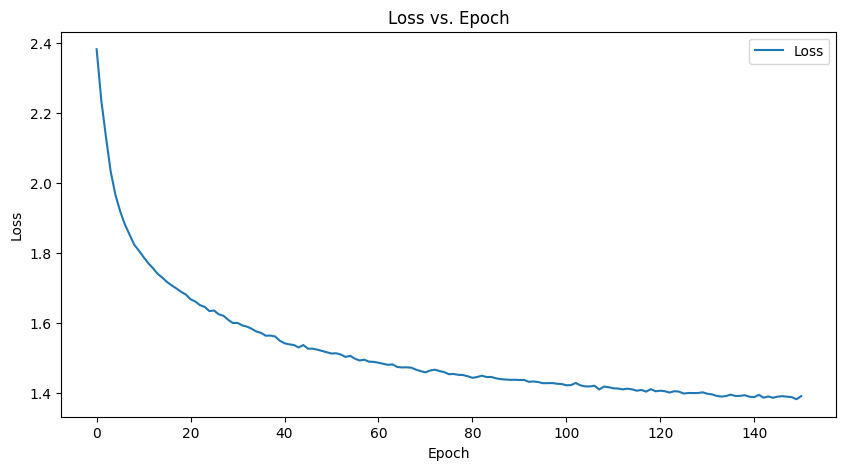

In [ ]:
# Plot the change of loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(nn_loss_optimised, label='Loss')  # Plot the loss values and label the line as 'Loss'
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()  # Display the plot

In [ ]:
# Print the final training and test accuracies
final_train_accuracy = training_accuracy[-1]  # Get the last recorded training accuracy
final_test_accuracy = test_accuracy[-1]  # Get the last recorded test accuracy

print(f'Final Training Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {final_test_accuracy * 100:.2f}%')

Final Training Accuracy: 57.59%
Final Test Accuracy: 53.20%


Training Confusion Matrix:
[[3253  230  246  136   67   50   68   91  543  316]
 [ 181 3385   56   69   41   11  112   56  270  819]
 [ 527  115 1952  450  453  490  527  285   96  105]
 [ 134   75  372 2033  122 1218  516  230   93  207]
 [ 349   85  767  301 1810  340  547  593   75  133]
 [  56   48  370 1076  142 2465  299  392   47  105]
 [  52  111  306  447  281  222 3390   62   26  103]
 [ 112   46  168  228  304  421   83 3399   34  205]
 [ 573  278   56  109   30   31   29   15 3572  307]
 [ 200  626   47   98   30   52   94  116  202 3535]]


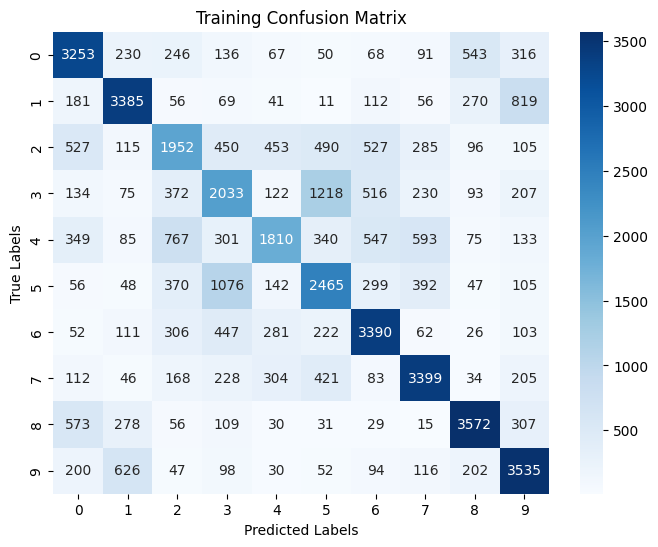

In [ ]:
# Generate predictions for training data
train_predictions = get_predictions(scaled_train_data, nn)

# Actual labels from one-hot to class labels for training dataset
train_actual_labels = np.argmax(onehot_train_label, axis=1)

# Compute confusion matrix for training data
train_conf_matrix = confusion_matrix(train_actual_labels, train_predictions)

# Print the training confusion matrix
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Visualize the training confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Test Confusion Matrix:
[[635  41  47  26  10  11  22  17 131  60]
 [ 36 619  14  20  12  10  23  18  54 194]
 [113  26 358  88  76 111 123  58  18  29]
 [ 28  17  73 371  37 223 124  57  18  52]
 [ 55  21 157  70 330  67 130 131  16  23]
 [ 21   9  73 215  31 444  81  82  18  26]
 [  6  21  61 106  70  38 642  19   8  29]
 [ 30   9  46  49  55  93  31 622   9  56]
 [124  70  11  24   6  17   8   8 653  79]
 [ 39 137  10  31   7  12  30  39  49 646]]


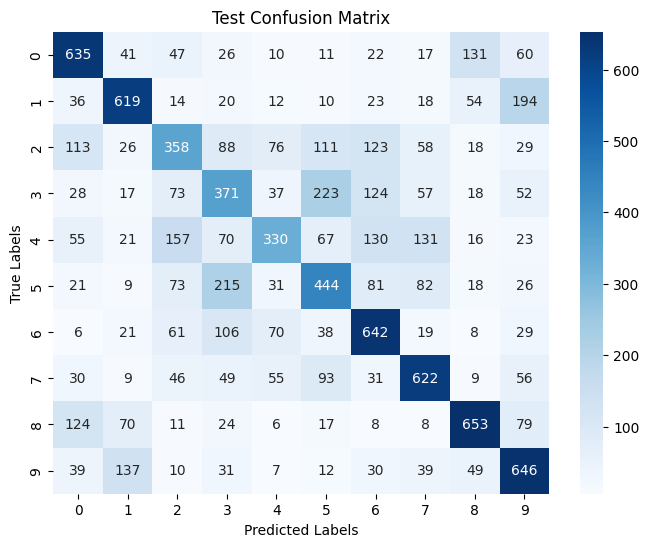

In [ ]:
# Generate predictions for test data
test_predictions = get_predictions(scaled_test_data, nn)

# Actual labels from one-hot to class labels for test dataset
test_actual_labels = np.argmax(onehot_test_label, axis=1)

# Compute confusion matrix for test data
test_conf_matrix = confusion_matrix(test_actual_labels, test_predictions)

# Print the test confusion matrix
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Visualize the test confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()